# Proccess Samples
This script takes raw measurement data, and spits out a "master data" spreadsheet with all data organized and including both raw and dip-adjusted depths

## Import Packages

In [1]:
# general
import numpy as np
import pandas as pd
from tqdm import tqdm

# plotting
import matplotlib.pyplot as plt
from collections import OrderedDict 

# math
from scipy.stats import pearsonr


# my functions/classes
import sys
sys.path.append("../core_scripts/")
from ECMclass import ECM
from ECMclass import core_section

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Setup

In [2]:
# Set filepaths

path_to_data = '../../data/'
path_to_figures = '../../../figures/'

## Load Dip Data

In [3]:
angles = pd.read_csv(path_to_data + 'angles/angles.csv')
angles.head()

,core,section,ACorDC,top_angle,left_angle,right_angle,side_angle,true_dip,true_dip_angles,true_dip_scores
0,alhic1901,228_4,AC,-36.776051,16.199769,-10.606322,13.403045,-38.643013,[-38.87808981 -38.54424142 -39.18075393 -37.73...,[0.88933205 0.97882252 0.95474921 0.95895482 0...
1,alhic1901,230_4,AC,27.819776,30.749623,-30.156336,30.452979,38.799076,[36.94242001 34.92239342 34.74296877 37.507310...,[0.99150915 0.99005042 0.99079277 0.99085791 0...


## Make some functions

In [4]:
# preform dip adjustment
def dip_adjust(angles,data):

    # Add 'top_angle' and 'side_angle' columns to data
    data['top_angle'] = data['section'].map(
        lambda sec: angles.loc[angles['section'] == sec, 'top_angle'].values[0]
    )
    data['side_angle'] = data['section'].map(
        lambda sec: angles.loc[angles['section'] == sec, 'side_angle'].values[0]
    )

    print("Mapped Angles")

    # make new depth columns
    data['top_depth_adj'] = data['top_depth'] + (
        data['effective_center_x'] * np.tan(data['top_angle'] * np.pi / 180) +
        data['effective_center_y'] * np.tan(data['side_angle'] * np.pi / 180))
    print("Adjusted top depth")
    data['bottom_depth_adj'] = data['bottom_depth'] + (
        data['effective_center_x'] * np.tan(data['top_angle'] * np.pi / 180) +
        data['effective_center_y'] * np.tan(data['side_angle'] * np.pi / 180))
    print("Adjusted bottom depth")
    data['mid_depth_adj'] = data['mid_depth'] + (
        data['effective_center_x'] * np.tan(data['top_angle'] * np.pi / 180) +
        data['effective_center_y'] * np.tan(data['side_angle'] * np.pi / 180))
    print("Adjusted mid depth")

    return (data)

In [5]:
# simple before/after plot
def simple_plot(data,prox,path_to_figures,dtype,oneline=True):

    print("Oneline is " + str(oneline))

    # pull out unique values in data['section']
    sections = data['section'].unique()

    # make a set of colors for plot lines using colormap
    cmap = plt.get_cmap('tab10')
    colors = [cmap(i) for i in range(len(data['stick'].unique()))]

    # make a plot for each core section
    for sec in sections:
        print("Plotting section " + str(sec))

        # filter for data in section
        df_sec = data.loc[data['section'] == sec]

        # new figure
        fig, ax = plt.subplots(len(prox), 2, figsize=(7, 2.5*len(prox)), dpi = 100, sharex=True)
        fig.suptitle('Section ' + str(sec))


        # new row for each proxy
        for i in range(len(prox)):
            print("    Plotting proxy " + prox[i])

            # filter for rows where this proxy does not contain NaN
            df_prox = df_sec.loc[~df_sec[prox[i]].isna()]

            # pull out data for this stick
            sticks = data['stick'].unique()

            # new line for each stick
            for j in range(len(sticks)):

                print("        Plotting stick " + str(sticks[j]))


                stick = sticks[j]

                # set label
                label = stick

                # pull out data for this stick
                df = df_prox.loc[df_sec['stick'] == stick]

                if len(df) == 0:
                    break
                
                if oneline:

                    # plot the data
                    ax[i,0].plot(
                        df['mid_depth'], 
                        df[prox[i]], 
                        color=colors[j],
                        label=label
                    )
                    ax[i,1].plot(
                        df['mid_depth_adj'], 
                        df[prox[i]], 
                        color=colors[j],
                        label=label
                    )

                    # for each data point, plot a line from 'top_depth' to 'bottom_depth' at the df[prox[i]] value
                    for k in range(len(df)):
                        ax[i,0].plot([df['top_depth'].iloc[k], df['bottom_depth'].iloc[k]], [df[prox[i]].iloc[k], df[prox[i]].iloc[k]], color=colors[j], alpha=0.5)
                        ax[i,1].plot([df['top_depth_adj'].iloc[k], df['bottom_depth_adj'].iloc[k]], [df[prox[i]].iloc[k], df[prox[i]].iloc[k]], color=colors[j], alpha=0.5)

                else:

                    # for each unique combination of effective_center_x and effective_center_y, plot a line
                    for x in df['effective_center_x'].unique():
                        for y in df['effective_center_y'].unique():

                            df_xy = df.loc[(df['effective_center_x'] == x) & (df['effective_center_y'] == y)]

                            if len(df_xy) == 0:
                                continue

                                                # plot the data

                            ax[i,0].plot(
                                df_xy['mid_depth'], 
                                df_xy[prox[i]], 
                                color=colors[j],
                                label=label
                            )
                            ax[i,1].plot(
                                df_xy['mid_depth_adj'], 
                                df_xy[prox[i]], 
                                color=colors[j],
                                label=label
                            )

                            label = '__nolegend__'

                # add labels
                ax[i,0].set_ylabel(prox[i])
                ax[i,1].set_ylabel(prox[i])
                ax[i,0].set_xlabel('Depth (m)')
                ax[i,1].set_xlabel('Depth (m)')
                ax[i,0].set_title(prox[i]+' - Before Dip Adjustment')
                ax[i,1].set_title(prox[i]+' - After Dip Adjustment')

                # add legend
                # handles, labels = ax.get_legend_handles_labels()
                # handle_list, label_list = [], []
                # for handle, label in zip(handles, labels):
                #     if label not in label_list:
                #         handle_list.append(handle)
                #         label_list.append(label)
                # plt.legend(handle_list, label_list)
                ax[i,0].legend(fontsize=8, loc='upper right')
                ax[i,1].legend(fontsize=8, loc='upper right')

        plt.tight_layout()
        fig.show()
        
        fig.savefig(path_to_figures + 'initial_dip_adjustment/' + dtype+'-'+ str(sec) + '.png', dpi=300)
                



## GHG data

## Water Isotopes

In [6]:
# load water isotope data
water_iso_data = pd.read_excel(path_to_data + '/sampling/water_iso/water_iso_data.xlsx')
water_iso_data.head()

,section,stick,top_depth,bottom_depth,mid_depth,dD,d17O,d18O,dxs
0,228_4,l_iso,155.0650,155.0750,155.0700,-296.18,-19.70,-37.03,0.07
1,228_4,l_iso,155.0761,155.0861,155.0811,-295.74,-19.69,-36.96,-0.05
2,228_4,l_iso,155.0873,155.0973,155.0923,-295.99,-19.72,-37.05,0.40
3,228_4,l_iso,155.0984,155.1084,155.1034,-296.24,-19.80,-37.22,1.49
4,228_4,l_iso,155.1095,155.1195,155.1145,-296.55,-19.90,-37.40,2.62


In [7]:
# load water isotope metadata

water_iso_metadata = pd.read_excel(path_to_data + '/sampling/water_iso/water_iso_metadata.xlsx')
water_iso_metadata.head()

,section,stick,x_lo,x_hi,y_lo,y_hi
0,230_4,l_iso,103,113,0,32
1,230_4,r_iso,60,83,72,92
2,228_4,c_iso,-15,15,-100,-115
3,228_4,l_iso,-110,-120,0,30
4,228_4,r_iso,120,100,0,30


In [8]:
# add metadata to water isotope data
# Merge water isotope data with metadata based on matching 'section' and 'Stick' columns
# Perform a manual merge using a loop
metadata_dict = water_iso_metadata.set_index(['section', 'stick']).to_dict(orient='index')

# Add metadata columns to water_iso_data
for idx, row in water_iso_data.iterrows():
    key = (row['section'], row['stick'])
    if key in metadata_dict:
        for col, value in metadata_dict[key].items():
            water_iso_data.at[idx, col] = value

# add columns for effective center
water_iso_data['effective_center_x'] = (water_iso_data['x_lo'] + water_iso_data['x_hi'])/2
water_iso_data['effective_center_y'] = (water_iso_data['y_lo'] + water_iso_data['y_hi'])/2

# divide effective_center and x/y lo/hi by 1000 to convert to m
water_iso_data['effective_center_x'] = water_iso_data['effective_center_x'] / 1000
water_iso_data['effective_center_y'] = water_iso_data['effective_center_y'] / 1000
water_iso_data['x_lo'] = water_iso_data['x_lo'] / 1000
water_iso_data['x_hi'] = water_iso_data['x_hi'] / 1000
water_iso_data['y_lo'] = water_iso_data['y_lo'] / 1000
water_iso_data['y_hi'] = water_iso_data['y_hi'] / 1000

water_iso_data.head()

,section,stick,top_depth,bottom_depth,mid_depth,dD,d17O,d18O,dxs,x_lo,x_hi,y_lo,y_hi,effective_center_x,effective_center_y
0,228_4,l_iso,155.0650,155.0750,155.0700,-296.18,-19.70,-37.03,0.07,-0.11,-0.12,0.0,0.03,-0.115,0.015
1,228_4,l_iso,155.0761,155.0861,155.0811,-295.74,-19.69,-36.96,-0.05,-0.11,-0.12,0.0,0.03,-0.115,0.015
2,228_4,l_iso,155.0873,155.0973,155.0923,-295.99,-19.72,-37.05,0.40,-0.11,-0.12,0.0,0.03,-0.115,0.015
3,228_4,l_iso,155.0984,155.1084,155.1034,-296.24,-19.80,-37.22,1.49,-0.11,-0.12,0.0,0.03,-0.115,0.015
4,228_4,l_iso,155.1095,155.1195,155.1145,-296.55,-19.90,-37.40,2.62,-0.11,-0.12,0.0,0.03,-0.115,0.015


In [9]:
# preform dip adjustment
water_iso_master = dip_adjust(angles,water_iso_data)

# save data
water_iso_master.to_csv(path_to_data + 'sampling/master/water_iso_master.csv', index=False)

water_iso_master.head()

Mapped Angles
Adjusted top depth
Adjusted bottom depth
Adjusted mid depth


,section,stick,top_depth,bottom_depth,mid_depth,dD,d17O,d18O,dxs,x_lo,x_hi,y_lo,y_hi,effective_center_x,effective_center_y,top_angle,side_angle,top_depth_adj,bottom_depth_adj,mid_depth_adj
0,228_4,l_iso,155.0650,155.0750,155.0700,-296.18,-19.70,-37.03,0.07,-0.11,-0.12,0.0,0.03,-0.115,0.015,-36.776051,13.403045,155.15453,155.16453,155.15953
1,228_4,l_iso,155.0761,155.0861,155.0811,-295.74,-19.69,-36.96,-0.05,-0.11,-0.12,0.0,0.03,-0.115,0.015,-36.776051,13.403045,155.16563,155.17563,155.17063
2,228_4,l_iso,155.0873,155.0973,155.0923,-295.99,-19.72,-37.05,0.40,-0.11,-0.12,0.0,0.03,-0.115,0.015,-36.776051,13.403045,155.17683,155.18683,155.18183
3,228_4,l_iso,155.0984,155.1084,155.1034,-296.24,-19.80,-37.22,1.49,-0.11,-0.12,0.0,0.03,-0.115,0.015,-36.776051,13.403045,155.18793,155.19793,155.19293
4,228_4,l_iso,155.1095,155.1195,155.1145,-296.55,-19.90,-37.40,2.62,-0.11,-0.12,0.0,0.03,-0.115,0.015,-36.776051,13.403045,155.19903,155.20903,155.20403


Oneline is True
Plotting section 228_4
    Plotting proxy d18O
        Plotting stick l_iso
        Plotting stick r_iso
        Plotting stick c_iso
    Plotting proxy dD
        Plotting stick l_iso
        Plotting stick r_iso
        Plotting stick c_iso
    Plotting proxy dxs
        Plotting stick l_iso
        Plotting stick r_iso
        Plotting stick c_iso


/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_73602/565663757.py:121: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Plotting section 230_4
    Plotting proxy d18O
        Plotting stick l_iso
        Plotting stick r_iso
        Plotting stick c_iso
    Plotting proxy dD
        Plotting stick l_iso
        Plotting stick r_iso
        Plotting stick c_iso
    Plotting proxy dxs
        Plotting stick l_iso
        Plotting stick r_iso
        Plotting stick c_iso


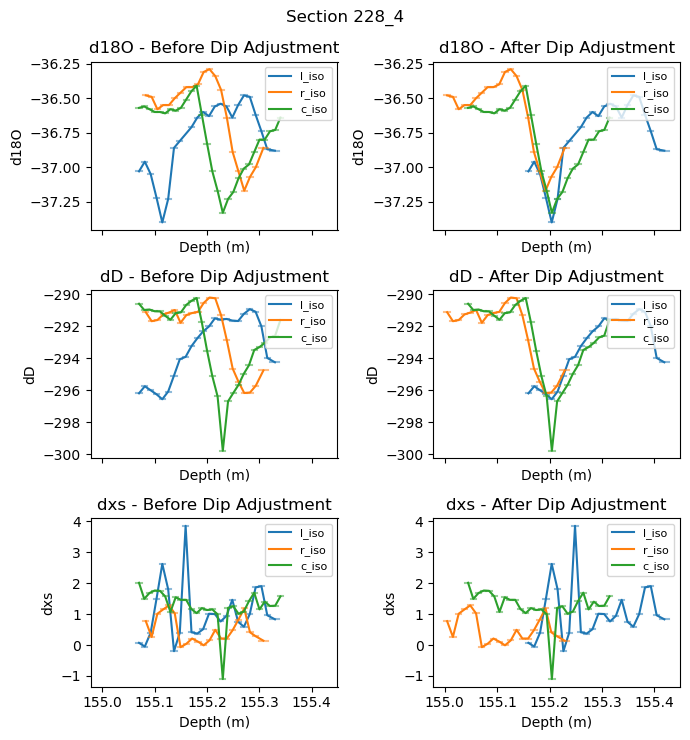

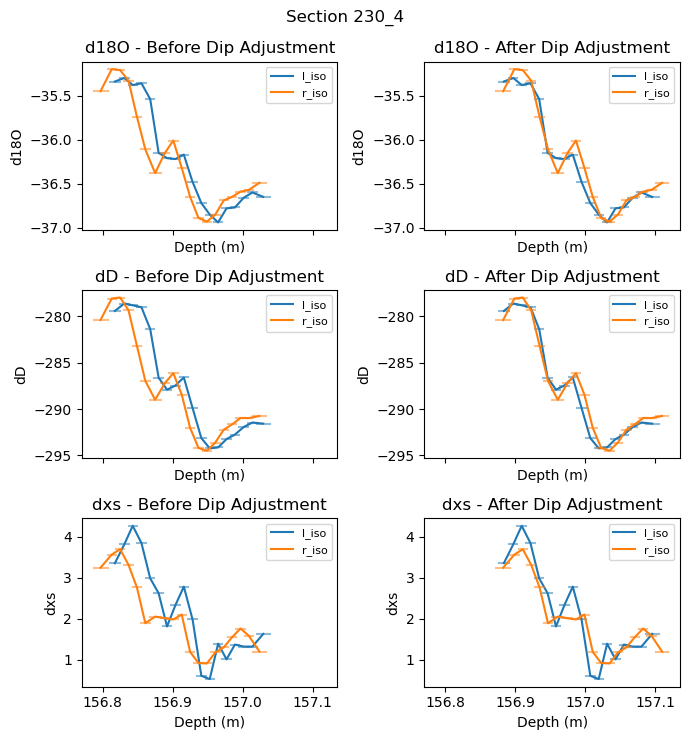

In [10]:
simple_plot(water_iso_data,['d18O','dD','dxs'],path_to_figures,'water_iso')